# PROYECTO FINAL: TELECOMUNICACIONES - IDENTIFICAR OPERADORES INEFICACES

## Descripción:

Identificar y cuantificar las ineficiencias operativas dentro del servicio de telefonía virtual CallMeMaybe, mediante el análisis de registros de actividad y el cálculo de indicadores de desempeño. A través de este análisis, se busca generar hallazgos clave que permitan a los supervisores detectar oportunamente a los operadores con menor rendimiento, facilitando la toma de decisiones estratégicas orientadas a mejorar la eficiencia operativa y elevar la calidad del servicio.

De acuerdo con la definición de negocio de CallMeMaybe, un operador es ineficaz si cumple con los siguientes puntos:
1. Tiene una gran cantidad de llamadas entrantes perdidas (tanto internas como externas) y su tiempo de espera es prolongado para llamadas entrantes.
2. Tiene un número reducido de llamadas salientes (si se espera que el operador las realice).


## 1. Inicialización

In [48]:
# Cargar las librerias necesarias
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import pearsonr

## 2. Carga de datos

In [49]:
# Crear el DataFrame con la información de los operadores y las llamadas.
df_calls_control = pd.read_csv("/datasets/telecom_dataset_us.csv")

# Crear el DataFrame con la información de los clientes. 
df_clients = pd.read_csv("/datasets/telecom_clients_us.csv")

## 3. Preprocesamiento de datos

In [50]:
# Validar la estructura de cada DataFrame:
# a. Conocer el total de registros. 
# b. Conocer el total de columnas. 
# c. Validar los tipos de dato en cada columna.
# d. Validar si existen valores ausentes.
# 2. Mostrar los 10 primeros registros de cada DataFrame.
df_calls_control.info()
print()
print(df_calls_control.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB

   user_id                       date direction internal  operator_id  \
0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2   166377  2019-08-05 00:00:00+03:00       out    

Observaciones: 
1. De los 53,902 registros que componen el dataset original, únicamente 45,730 tienen asignado un identificador de operador. Esto significa que existen 8,172 registros de llamadas que no están asociadas a ningún operador. Como el objetivo del análisis es identificar a los operadores que son ineficaces y dado a que no hay forma de asignar estos 8,172 a operadores específicos, lo más conveniente es eliminarlos del conjunto de datos a analizar.
2. Los identificadores de usuario aparecen como números enteros. No obstante, no se realizarán operaciones matemáticas con ellos como suma, resta, multiplicación, división, etc, por lo que resulta más conveniente manejarlos como cadenas de texto.
3. Los identificadores de operadores aparecen como números decimales. Al igual que sucede con los identificadores de usuario, resulta más conveniente manejarlos como cadenas de texto.
4. Las fechas de las estadísticas aparecen como cadenas de texto. Se convertirán a datetime dado que así se pueden extraer fácilmente año, més, día, calcular diferencias entre fechas, agrupar por periodos, etc.
5. De los 53,902 registros que componen el dataset original, únicamente 53,785 tienen indicador de llamada entrante o saliente. Existen 117 registros de llamadas para los cuales se desconoce si fueron de entrada o salida. No obstante, debido a que una de las métricas establecidas por el negocio de CallMeMaybe para identificar a un operador ineficaz es una gran cantidad de llamadas entrantes perdidas tanto internas como externas, no se discriminarán estos registros en el preprocesamiento de datos.
6. La estructura de las fechas de las estadísticas es AAAA-MM-DD HH:MM:SS+03:00 (por ejemplo, 2019-08-06 00:00:00+03:00), que corresponde al formato estándar ISO 8601. La marca temporal HH:MM:SS es una indicación de que los datos se encuentran resumidos por día. El +03:00 indica el desplazamiento de zona horaria. 

Existen 3 columnas categóricas binarias:
1. direction. Valores "in" (para llamadas entrantes) y "out" (para llamadas salientes). 
2. internal. Valores "True" (para llamadas internas) y "False" (para llamadas externas).
3. is_missed_call. Valores "True" (para llamadas perdidas) y "False" (para llamadas que no se perdieron).

Para que resulte más sencillo obtener valores estadísticos de estas tres columnas, sus valores se reemplazarán de la siguiente manera:
1. direction. "in" cambia a 1 y "out" a 0.
2. internal. "True" cambia a 1 y "False" cambia a 0.
3. is_missed_call. "True" cambia a 1 y "False" cambia a 0.

In [51]:
# Filtrar los registros sin identificador de operador.
df_calls_with_no_operator = df_calls_control[df_calls_control["operator_id"].isna()]
# Validar que sean 8,172 registros sin identificador de operador. 
print("Número de registros sin operador: ", len(df_calls_with_no_operator))

# Eliminar los registros que no tienen identificador de operador. 
df_calls_control.dropna(subset=["operator_id"], inplace=True)

Número de registros sin operador:  8172


In [52]:
# Validar si existe duplicados idénticos en el DataFrame de operadores y llamadas. 
print("Total de registros duplicados idénticos: ", df_calls_control.duplicated().sum())

Total de registros duplicados idénticos:  4184


Observaciones: 
1. Existen 4,184 registros duplicados idénticos. Como cada fila del conjunto de datos representa un resumen de llamadas agregadas para una fecha, un operador, un cliente y una dirección específicas, se eliminarán estos registros del conjunto de datos para no generar inflación no deseada al calcular las métricas de ineficiencia. 

In [53]:
# Eliminar los registros duplicados idénticos. 
df_calls_control.drop_duplicates(inplace=True)

In [54]:
# Convertir la columna de identificador de usuario a cadena. 
df_calls_control["user_id"] = df_calls_control["user_id"].astype(str)

# Eliminar el punto decimal de los identificadores de operador y convertirlos a cadena. 
df_calls_control["operator_id"] = df_calls_control["operator_id"].astype(int)
df_calls_control["operator_id"] = df_calls_control["operator_id"].astype(str)

# Convertir la columna de fecha de estadísticas a datetime. 
df_calls_control["date"] = pd.to_datetime(df_calls_control["date"])

# Reemplazar los valores in (llamdas entrantes) y out (llamadas salientes) por 1 y 0, respectivamente. 
df_calls_control["direction"] = df_calls_control["direction"].replace({"in": 1, "out": 0})

# Reemplazar los valores True y False de las columnas internal y is_missed_call por 1 y 0, respectivamente. 
df_calls_control["internal"] = df_calls_control["internal"].replace({True: 1, False: 0})
df_calls_control["is_missed_call"] = df_calls_control["is_missed_call"].replace({True: 1, False: 0})

In [55]:
# Estudiar el DataFrame de operadores y llamadas después de los ajustes realizados.
df_calls_control.info()
#print(df_calls_control.sample(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41546 entries, 1 to 53899
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              41546 non-null  object                               
 1   date                 41546 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            41546 non-null  int64                                
 3   internal             41491 non-null  float64                              
 4   operator_id          41546 non-null  object                               
 5   is_missed_call       41546 non-null  int64                                
 6   calls_count          41546 non-null  int64                                
 7   call_duration        41546 non-null  int64                                
 8   total_call_duration  41546 non-null  int64                                
dtypes: date

Observaciones: 
1. El total de valores ausentes de la columna de identificador de llamadas internas y externas disminuyó de 117 a 55 (más del 50%).
2. Al reemplazar en la columna de identificador de llamadas internas y externas los valores True y False por 1 y 0, respectivamente, pandas convirtió automáticamente la columna a flotante. Esto debido a que la columna contiene valores ausentes (NaN) y los enteros no pueden representar valores NaN. Como se mencionó previamente, debido a que una de las métricas establecidas por el negocio de CallMeMaybe para identificar a un operador ineficaz es una gran cantidad de llamadas entrantes perdidas tanto internas como externas, no se discriminarán los registros NaN en el preprocesamiento de datos y se mantendrá a la columna de identificador de llamadas internas y externas como flotante. 

In [56]:
df_clients.info()
print()
print(df_clients.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB

     user_id tariff_plan  date_start
665   166421           B  2019-08-02
191   168110           C  2019-10-14
284   166688           C  2019-08-15
484   167077           B  2019-08-30
345   166679           C  2019-08-14
359   166621           C  2019-08-12
474   168103           B  2019-10-14
39    166465           A  2019-08-05
138   168515           C  2019-10-29
512   168513           B  2019-10-29


Observaciones:
1. El conjunto de datos de clientes no tiene valores ausentes en ninguna de sus columnas.
2. Los identificadores de usuario aparecen como números enteros. No obstante, no se realizarán operaciones matemáticas con ellos como suma, resta, multiplicación, división, etc, por lo que resulta más conveniente manejarlos como cadenas de texto.
3. Las fechas de registro de los clientes aparecen como cadenas de texto. Se convertirán a datetime dado que así se pueden extraer fácilmente año, més, día, calcular diferencias entre fechas, agrupar por periodos, etc.

In [57]:
# Convertir la columna de identificador de usuario a cadena. 
df_clients["user_id"] = df_clients["user_id"].astype(str)

# Convertir la columna de fecha de registro de la clientela a datetime.
df_clients["date_start"] = pd.to_datetime(df_clients["date_start"])

In [58]:
# Validar si existe duplicados idénticos en el DataFrame de clientes. 
print("Total de registros duplicados idénticos: ", df_clients.duplicated().sum())

Total de registros duplicados idénticos:  0


In [59]:
# Crear un DataFrame que combine los registros de operadores y llamadas con los de clientes en caso de que resulte de utilidad para el análisis. 
df_merged = df_calls_control.merge(
    df_clients, 
    on = "user_id",
    how = "left" # Utilizar LEFT JOIN para mantener los registros de llamadas. 
)

print(df_merged.head())

  user_id                      date  direction  internal operator_id  \
0  166377 2019-08-05 00:00:00+03:00          0       1.0      880022   
1  166377 2019-08-05 00:00:00+03:00          0       1.0      880020   
2  166377 2019-08-05 00:00:00+03:00          0       1.0      880020   
3  166377 2019-08-05 00:00:00+03:00          0       0.0      880022   
4  166377 2019-08-05 00:00:00+03:00          0       0.0      880020   

   is_missed_call  calls_count  call_duration  total_call_duration  \
0               1            3              0                    5   
1               1            1              0                    1   
2               0            1             10                   18   
3               1            3              0                   25   
4               0            2              3                   29   

  tariff_plan date_start  
0           B 2019-08-01  
1           B 2019-08-01  
2           B 2019-08-01  
3           B 2019-08-01  
4          

## 4. Análisis exploratorio de datos 

In [60]:
# Contar el número de operadores únicos contenidos en el conjunto de datos preprocesado. 
print("Total de operadores:", df_calls_control["operator_id"].nunique())

Total de operadores: 1092


In [61]:
# Validar qué periodo comprende el conjunto de datos preprocesado. 
min_date = df_calls_control["date"].min()
max_date = df_calls_control["date"].max()
print(f"El conjunto de datos comprende de {min_date} a {max_date}.")

El conjunto de datos comprende de 2019-08-02 00:00:00+03:00 a 2019-11-28 00:00:00+03:00.


Observaciones: 
1. Se considera un periodo cuatrimestral para el análisis de los datos. 

In [62]:
# Analizar valores estadísticos. 
print(df_calls_control.describe()) 

          direction      internal  is_missed_call   calls_count  \
count  41546.000000  41491.000000    41546.000000  41546.000000   
mean       0.306480      0.128462        0.339624     16.900424   
std        0.461037      0.334607        0.473587     59.749373   
min        0.000000      0.000000        0.000000      1.000000   
25%        0.000000      0.000000        0.000000      1.000000   
50%        0.000000      0.000000        0.000000      4.000000   
75%        1.000000      0.000000        1.000000     13.000000   
max        1.000000      1.000000        1.000000   4817.000000   

       call_duration  total_call_duration  
count   41546.000000         41546.000000  
mean     1009.769172          1321.592813  
std      4064.106117          4785.978633  
min         0.000000             0.000000  
25%         0.000000            67.000000  
50%       106.000000           288.000000  
75%       770.000000          1104.000000  
max    144395.000000        166155.000000  


Observaciones:

Para las variables categóricas binarias:
1. Predominan las llamadas salientes. Aproximadamente el 30.65% de los registros de llamadas son entrantes (direction = in (1)), mientras que el 69.35% son salientes (direction = out (0)).
2. Predominan las llamadas externas. Sólo el 12.85% de las llamadas son internas (entre operadores), mientras que el 87.15% son llamadas externas.
3. Existe un alto índice de llamadas perdidas. El 33.96% de los registros de llamadas son llamadas perdidas, lo cual significa que aproximadamente 1 de cada 3 llamadas se pierde.

Para las variables de conteo y duración de llamadas:
1. Para el conteo de llamadas, la media (16.9) es casi 4 veces menor que la desviación estándar (59.75). Esto sugiere que gran parte de los registros representa un número pequeño de llamadas y que pocos registros representan números grandes de llamadas, lo cual puede relacionarse con los valores mínimo y máximo de 1 y 4,817 llamadas, respectivamente. Existen outliers (la media (16.9) es mayor a la mediana (4)). 
2. El 50% de las llamadas (sin incluir tiempo de espera) duran menos de 106 segundos (1 minutos y 46 segundos). La media es de aproximadamente 1010 segundos (casi 17 minutos) lo que sugiere que existen outliers que están elevando la media. Esto es observable en el valor máximo de duración sin tiempo de espera de 144,395 segundos (aproximadamente 40 horas). La baja mediana sugiere que la mayoría de las llamadas son cortas.
3. El 50% de las llamadas (con tiempo de espera) duran 288 segundos (aproximadamente casi 5 minutos). Al igual que sucede con la duración de llamadas sin tiempo de espera, la media está sesgada por outliers. El valor máximo es 166,155 segundos (aproximadamente 46 horas).

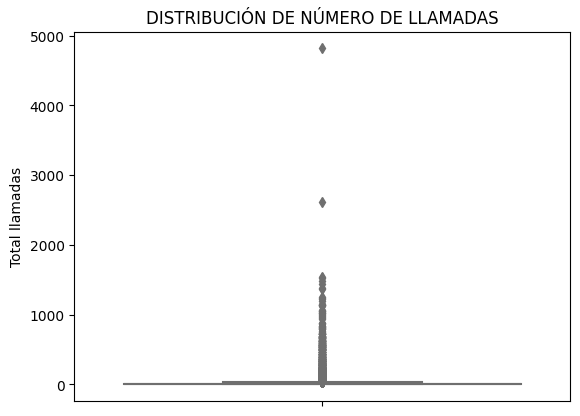

In [63]:
# Trazar un gráfico de caja para ver la distribución del número de llamadas.
sns.boxplot(y="calls_count", data=df_calls_control, color="skyblue")
plt.title("DISTRIBUCIÓN DE NÚMERO DE LLAMADAS")
plt.ylabel("Total llamadas")
plt.show()

Observaciones: 
1. No son distinguibles los bigotes ni los cuartiles Q1, Q2 y Q3.
2. Es necesario limitar el eje Y del gráfico para eliminar los valores extremos que impiden que la caja del gráfico se distinga con claridad. 

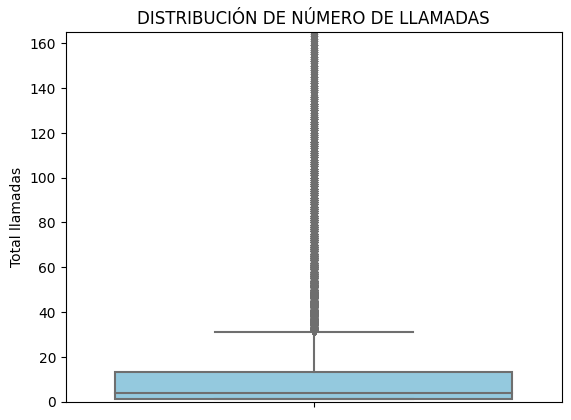

In [64]:
 # Calcular el percentil 99 para limitar el eje Y, es decir, encontrar le valor donde el 99% de los datos están por debajo. 
percentile_99 = df_calls_control["calls_count"].quantile(0.99)


sns.boxplot(y="calls_count", data=df_calls_control, color="skyblue")
plt.ylim(0, percentile_99)
plt.title("DISTRIBUCIÓN DE NÚMERO DE LLAMADAS")
plt.ylabel("Total llamadas")
plt.show()

Observaciones:
1. El cuartil Q2 (la mediana) muestra que la mitad de los registros diarios representan 4 llamadas o menos, es decir, la actividad diaria típica es baja.  
2. El cuartil Q3 (borde superior de la caja) muestra que el 75% de los registros tienen un número de llamadas aproximado de 13, lo cual sigue representando un número de llamadas bajo.
3. El bigote superior indica el valor extremo máximo de número de llamadas, el cual se sitúa aproximadamente en 30.Sin embargo, al aplicar el percentil 99, se observa que se extiende a aproximadamente 165.
4. Los outliers extremos que superan el percentil 99 (≈165) se truncaron. 

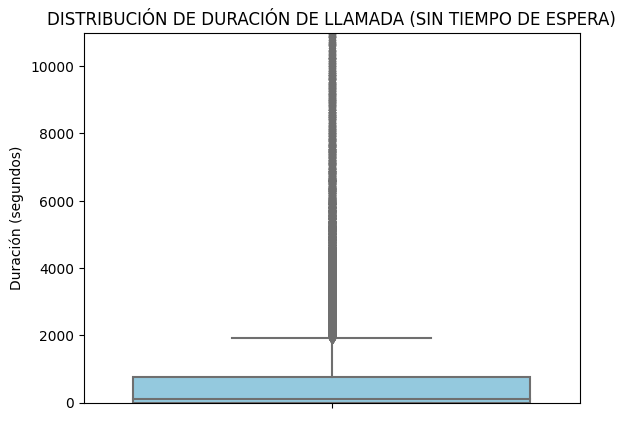

In [65]:
# Trazar un gráfico de caja para ver la distribución de la duración de llamadas (sin tiempo de espera).
percentile_99 = df_calls_control["call_duration"].quantile(0.99)
sns.boxplot(y="call_duration", data=df_calls_control, color="skyblue")
plt.ylim(0, percentile_99)
plt.title("DISTRIBUCIÓN DE DURACIÓN DE LLAMADA (SIN TIEMPO DE ESPERA)")
plt.ylabel("Duración (segundos)")
plt.show()

Observaciones: 
1. El cuartil Q1 muestra que muchos registros tienen duración de 0 segundos. 
2. La mediana muestra que la mitad de las conversaciones son extremadamente cortas (muy cercanas a 0 segundos). 
3. El 75% de las conversaciones tienen una duración inferior a los 1000 segundos, es decir, son menores a 15 minutos.
4. El bigote superior se sitúa en 2000 segundos, pero al aplicar el percentil 99, se observa que se extiende hasta aproximadamente 11,000 segundos (3 horas), lo cual denota una gran variabilidad en la duración real de las llamadas.  

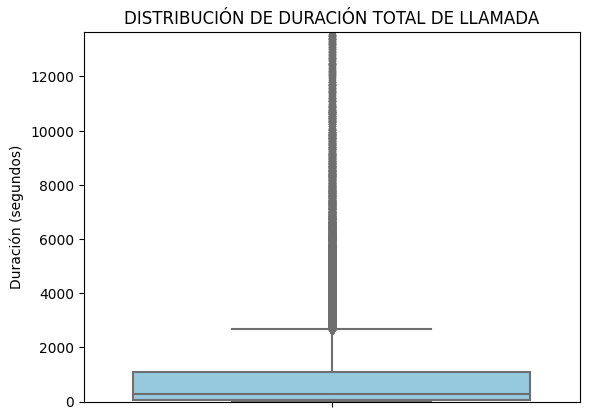

In [66]:
# Trazar un gráfico de caja para ver la distribución de la duración total de llamadas (con tiempo de espera).
percentile_99 = df_calls_control["total_call_duration"].quantile(0.99)
sns.boxplot(y="total_call_duration", data=df_calls_control, color="skyblue")
plt.ylim(0, percentile_99)
plt.title("DISTRIBUCIÓN DE DURACIÓN TOTAL DE LLAMADA")
plt.ylabel("Duración (segundos)")
plt.show()

Observaciones: 
1. La mediana muestra que el tiempo de interacción total es bajo para la mayoría de los registros (aproximadamente inferior a 300 segundos (5 minutos)). 
2. La caja de duración total de la llamada es visiblemente más grande que la de duración de llamada sin tiempo de espera, lo cual denota la existencia de tiempos de espera significativos. 
3. El bigote superior se sitúa arriba de los 2000 segundos (mayor a 30 minutos) y, al aplicar el percentil 99, se extiende hasta casi 14,000 segundos (casi 4 horas).

Como las distribuciones de las variables de número y duración de llamadas presentan distribuciones sesgadas y con una cantidad considerable de outliers extremos, se aplicará el método de Winsorización o capping por percentil. 

El uso de Winsorización crea nuevas columnas, lo cual es ideal, ya que conserva los datos originales y evita que los valores máximos y mínimos distorsionen las métricas. 

In [67]:
# Aplicar winsorización a cada una de las variables identificadas y 
# crear una nueva columna con los valores ajustados. 
def winsorize_column(df, column_name, lower_percentile=0.01, upper_percentile=0.99):
    # Calcular los límites (percentiles). 
    lower_bound = df[column_name].quantile(lower_percentile)
    upper_bound = df[column_name].quantile(upper_percentile)
    
    # Crear nueva columna winsorizada y aplicar el np.clip. 
    # clip limita los valores de cada columna entre el percentil más bajo y el percentil más alto seleccionados.
    winsorized_column = column_name + "_winsorized"
    df[winsorized_column] = df[column_name].clip(lower=lower_bound, upper=upper_bound)
    
    # Reportar los resultados: 
    print(f"Winsorización de {column_name}:")
    print(f"  Límite inferior (percentil {lower_percentile*100}%): {lower_bound:.2f}")
    print(f"  Límite superior (percentil {upper_percentile*100}%): {upper_bound:.2f}")
    print(f"  Valores reemplazados: {((df[column_name] < lower_bound) | (df[column_name] > upper_bound)).sum()}")
    print()
    
    return df

# Aplicar winsorización a las tres variables problemáticas:
# 1. calls_count (P1 y P99)
df_calls_control = winsorize_column(df_calls_control, "calls_count", 0.01, 0.99)
# 2. call_duration (P5 y P95)
df_calls_control = winsorize_column(df_calls_control, "call_duration", 0.05, 0.95)
# 3. total_call_duration (P5 y P95)
df_calls_control = winsorize_column(df_calls_control, "total_call_duration", 0.05, 0.95)


Winsorización de calls_count:
  Límite inferior (percentil 1.0%): 1.00
  Límite superior (percentil 99.0%): 165.00
  Valores reemplazados: 415

Winsorización de call_duration:
  Límite inferior (percentil 5.0%): 0.00
  Límite superior (percentil 95.0%): 4161.00
  Valores reemplazados: 2075

Winsorización de total_call_duration:
  Límite inferior (percentil 5.0%): 7.00
  Límite superior (percentil 95.0%): 5033.50
  Valores reemplazados: 4120



In [68]:
df_calls_control.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41546 entries, 1 to 53899
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype                                
---  ------                          --------------  -----                                
 0   user_id                         41546 non-null  object                               
 1   date                            41546 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction                       41546 non-null  int64                                
 3   internal                        41491 non-null  float64                              
 4   operator_id                     41546 non-null  object                               
 5   is_missed_call                  41546 non-null  int64                                
 6   calls_count                     41546 non-null  int64                                
 7   call_duration                   41546 non-null  int64              

Observaciones: Después de aplicar el método de Winsorización: 
1. Los 41,546 registros de llamadas que se tenían se conservan.
2. Los valores extremos fueron reemplazados por los percentiles definidos. 

In [69]:
# Calcular el número total de llamadas entrantes. 
print("RESUMEN DE LLAMADAS")
print("--------------------")
df_in_calls = df_calls_control[df_calls_control["direction"] == 1]
print("LLAMADAS ENTRANTES:")
print("Total general:", len(df_in_calls))
print()
# Calcular el número total de llamadas entrantes internas (sin considerar los 55 registros NaN).
df_in_calls_internal = df_in_calls[df_in_calls["internal"] == 1.0]
print("Total internas:", len(df_in_calls_internal))
# Calcular el número total de llamadas entrantes internas perdidas (sin considerar los 55 registros NaN)
df_in_calls_internal_missed = df_in_calls_internal[df_in_calls_internal["is_missed_call"] == 1]
print("Total internas perdidas:", len(df_in_calls_internal_missed))
# Calcular el número total de llamadas entrantes internas tomadas (sin considerar los 55 registros NaN)
df_in_calls_internal_taken = df_in_calls_internal[df_in_calls_internal["is_missed_call"] == 0]
print("Total internas tomadas:", len(df_in_calls_internal_taken))
print()
# Calcular el número total de llamadas entrantes externas (sin considerar los 55 registros NaN).
df_in_calls_external = df_in_calls[df_in_calls["internal"] == 0.0]
print("Total externas:", len(df_in_calls_external))
# Calcular el número total de llamadas entrantes externas perdidas (sin considerar los 55 registros NaN)
df_in_calls_external_missed = df_in_calls_external[df_in_calls_external["is_missed_call"] == 1]
print("Total externas perdidas:", len(df_in_calls_external_missed))
# Calcular el número total de llamadas entrantes externas tomadas (sin considerar los 55 registros NaN)
df_in_calls_external_taken = df_in_calls_external[df_in_calls_external["is_missed_call"] == 0]
print("Total externas tomadas:", len(df_in_calls_external_taken))
print("--------------------")

# Calcular el número total de llamadas salientes. 
df_out_calls = df_calls_control[df_calls_control["direction"] == 0]
print("LLAMADAS SALIENTES:")
print("Total general:", len(df_out_calls))
print()
# Calcular el número total de llamadas salientes internas (sin considerar los 55 registros NaN).
df_out_calls_internal = df_out_calls[df_out_calls["internal"] == 1.0]
print("Total internas:", len(df_out_calls_internal))
# Calcular el número total de llamadas salientes internas perdidas (sin considerar los 55 registros NaN)
df_out_calls_internal_missed = df_out_calls_internal[df_out_calls_internal["is_missed_call"] == 1]
print("Total internas perdidas:", len(df_out_calls_internal_missed))
# Calcular el número total de llamadas salientes internas tomadas (sin considerar los 55 registros NaN)
df_out_calls_internal_taken = df_out_calls_internal[df_out_calls_internal["is_missed_call"] == 0]
print("Total internas tomadas:", len(df_out_calls_internal_taken))
print()
# Calcular el número total de llamadas salientes externas (sin considerar los 55 registros NaN).
df_out_calls_external = df_out_calls[df_out_calls["internal"] == 0.0]
print("Total externas:", len(df_out_calls_external))
# Calcular el número total de llamadas salientes externas perdidas (sin considerar los 55 registros NaN)
df_out_calls_external_missed = df_out_calls_external[df_out_calls_external["is_missed_call"] == 1]
print("Total externas perdidas:", len(df_out_calls_external_missed))
# Calcular el número total de llamadas salientes externas tomadas (sin considerar los 55 registros NaN)
df_out_calls_external_taken = df_out_calls_external[df_out_calls_external["is_missed_call"] == 0]
print("Total externas tomadas:", len(df_out_calls_external_taken))


RESUMEN DE LLAMADAS
--------------------
LLAMADAS ENTRANTES:
Total general: 12733

Total internas: 386
Total internas perdidas: 21
Total internas tomadas: 365

Total externas: 12292
Total externas perdidas: 663
Total externas tomadas: 11629
--------------------
LLAMADAS SALIENTES:
Total general: 28813

Total internas: 4944
Total internas perdidas: 2391
Total internas tomadas: 2553

Total externas: 23869
Total externas perdidas: 11034
Total externas tomadas: 12835


In [70]:

# Calcular el tiempo de espera tomando las columnas winsorizadas de duración de llamada:
# a. call_duration_winsorized. Duración de llamada (sin incluir tiempo de espera).
# b. total_call_duration_winsorized. Duración de llamada (incluido el tiempo de espera).
# Tiempo de espera =  duración de llamada con tiempo de espera -  duración de llamada sin tiempo de espera
df_calls_control["waiting_time_winsorized"] = (df_calls_control["total_call_duration_winsorized"] - df_calls_control["call_duration_winsorized"]).astype(int)

# Crear una columna para registrar si la llamada es entrante y perdida:
# a. df_calls_control['is_missed_call'] == 1 : Máscara booleana que establece la condición de si la llamada es perdida. 
# b. df_calls_control['direction'] == 1 : Máscara booleana que establece la condición de si la llamada es entrante. 
# c. Convertir de True y False a 1 y 0 con astype(int). 1 significa que la llamada entrante es perdida, 0 indica que la llamada entrante no es perdida. 
df_calls_control['is_missed_in_call'] = ((df_calls_control['is_missed_call'] == 1) & (df_calls_control['direction'] == 1)).astype(int)

# Segmentar la columna direction en dos columnas:
# a. Una que identifique las llamadas entrantes únicamente: 1 = entrante, 0 = saliente.
df_calls_control['is_in_call'] = (df_calls_control['direction'] == 1).astype(int)
# b. Una que identifique las llamadas salientes únicamente: 1 =  saliente, 0 = entrante.
df_calls_control['is_out_call'] = (df_calls_control['direction'] == 0).astype(int)


In [71]:
# Crear un DataFrame agregado por operador que consolide los datos necesarios para calcular las métricas de ineficiencia:
# a. Total de llamadas entrantes perdidas. 
# b. Tiempo de espera prolongado para llamadas entrantes. 
# c. Total de llamadas salientes. 
df_operator_metrics = df_calls_control.groupby("operator_id").agg(
    total_in_calls = ("is_in_call", "sum"), # Total de llamadas entrantes.
    total_missed_in_calls = ("is_missed_in_call", "sum"), # Total de llamadas entrantes perdidas.
    total_out_calls = ("is_out_call", "sum"), # Total de llamadas salientes.
    total_waiting_time = ("waiting_time_winsorized", lambda x: x[df_calls_control.loc[x.index, 'is_in_call'] == 1].sum()), # Total de tiempo de espera para llamadas entrantes 
    total_calls_with_waiting_time = ("waiting_time_winsorized", lambda x: x[df_calls_control.loc[x.index, 'is_in_call'] == 1].count()) # Total de llamadas entrantes con tiempo de espera.
).reset_index()

print(df_operator_metrics.head(10))

  operator_id  total_in_calls  total_missed_in_calls  total_out_calls  \
0      879896              21                      0               96   
1      879898              57                      0              170   
2      880020               7                      0               13   
3      880022               8                      0               62   
4      880026              18                      0              164   
5      880028              41                      0              161   
6      880240               0                      0               12   
7      881278               0                      0                8   
8      882476               3                      0                0   
9      882478               2                      0                1   

   total_waiting_time  total_calls_with_waiting_time  
0                 574                             21  
1                1680                             57  
2                  54          

In [72]:
# Calcular las métricas de ineficiencia:
# a. Tasa de pérdida de llamadas entrantes: (Total de llamadas entrantes perdidas dividido por total de llamadas entrante) * 100
df_operator_metrics["in_calls_loss_rate"] = (df_operator_metrics["total_missed_in_calls"] / df_operator_metrics["total_in_calls"])*100
# b. Tiempo promedio de espera: Tiempo de espera dividido por total de llamadas con tiempo de espera. 
df_operator_metrics["average_waiting_time"] = df_operator_metrics["total_waiting_time"] / df_operator_metrics["total_calls_with_waiting_time"]
# c. Cantidad de llamadas salientes: 
# Columna ya existente df_operator_metrics["total_out_calls"]

# Manejar los casos en los que:
# a. Un operador no tiene llamadas entrantres. Su tasa de pérdida es igual a 0% (si no recibe, no tiene).
df_operator_metrics["in_calls_loss_rate"] = df_operator_metrics["in_calls_loss_rate"].fillna(0)
# b. Un operador no tiene tiempo de espera. Su tiempo de espera promedio es 0.
df_operator_metrics["average_waiting_time"] = df_operator_metrics["average_waiting_time"].fillna(0)

print(df_operator_metrics.head(10))

  operator_id  total_in_calls  total_missed_in_calls  total_out_calls  \
0      879896              21                      0               96   
1      879898              57                      0              170   
2      880020               7                      0               13   
3      880022               8                      0               62   
4      880026              18                      0              164   
5      880028              41                      0              161   
6      880240               0                      0               12   
7      881278               0                      0                8   
8      882476               3                      0                0   
9      882478               2                      0                1   

   total_waiting_time  total_calls_with_waiting_time  in_calls_loss_rate  \
0                 574                             21                 0.0   
1                1680                       

In [73]:
# Establecer los umbrales para definir la ineficiencia: 
# a. Para la tasa de perdida de llamadas: Percentil 80 (Q3). Los valores altos representan ineficiencia.
threshold_missed_in_calls = df_operator_metrics["in_calls_loss_rate"].quantile(0.80)
# b. Para el tiempo promedio de espera: Percentil 75 (Q3). Los valores altos representan ineficiencia.
threshold_waiting_time = df_operator_metrics["average_waiting_time"].quantile(0.75)
# c. Para la cantidad de llamadas salientes: Percentil 25 (Q1). Los valores altos representan ineficiencia. 
threshold_out_calls = df_operator_metrics["total_out_calls"].quantile(0.25)

In [74]:
# Establecer el sistema de puntuación binaria: 
# Alta pérdida de Llamadas entrantes:
# 1. Comparar el resultado de cada operador con el umbral establecido para ineficiencia. 
# 2. Si el valor supera el umbral, se le asigna la puntuación binaria 1, es decir, que el operador es ineficaz.
# 3. Si el valor no supera el umbral, se le asgina la puntuación binaria 0. 
df_operator_metrics['score_missed_in_calls'] = (df_operator_metrics['in_calls_loss_rate'] > threshold_missed_in_calls).astype(int)
# Tiempo promedio largo de espera: 
# 1. Comparar el resultado de cada operador con el umbral establecido para ineficiencia. 
# 2. Si el valor supera el umbral, se le asigna la puntuación binaria 1, es decir, que el operador es ineficaz.
# 3. Si el valor no supera el umbral, se le asgina la puntuación binaria 0. 
df_operator_metrics['score_waiting_time'] = (df_operator_metrics['average_waiting_time'] > threshold_waiting_time).astype(int)
# Baja productividad en llamadas salientes:
# 1. Comparar el resultado de cada operador con el umbral establecido para ineficiencia. 
# 2. Si el valor supera el umbral, se le asigna la puntuación binaria 0.
# 3. Si el valor no supera el umbral, se le asgina la puntuación binaria 1, es decir, que el operador es ineficaz. 
df_operator_metrics['score_out_calls'] = (df_operator_metrics['total_out_calls'] < threshold_out_calls).astype(int)

In [75]:
# Crear una columna de puntuación total de ineficiencia: 
df_operator_metrics["inefficiency_score"] = df_operator_metrics["score_missed_in_calls"] + df_operator_metrics["score_waiting_time"] +  df_operator_metrics["score_out_calls"]
print(df_operator_metrics[["operator_id","score_missed_in_calls", "score_waiting_time", "score_out_calls", "inefficiency_score"]].sort_values(by=["inefficiency_score"], ascending=False))
#print(df_operator_metrics[["score_missed_in_calls", "score_waiting_time", "score_out_calls", "inefficiency_score"]].sort_values(by=["score_missed_in_calls", "score_waiting_time", "score_out_calls"], ascending=False))

    operator_id  score_missed_in_calls  score_waiting_time  score_out_calls  \
109      894120                      1                   1                1   
652      934534                      1                   1                1   
352      911138                      1                   1                1   
353      911140                      1                   1                1   
144      896536                      1                   1                1   
..          ...                    ...                 ...              ...   
635      933806                      0                   0                0   
636      933810                      0                   0                0   
249      905432                      0                   0                0   
639      933996                      0                   0                0   
0        879896                      0                   0                0   

     inefficiency_score  
109                   3  

In [76]:
# Considerar los dos criterios establecidos por el negocio. Un operador es ineficaz si: 
# a. Tiene una gran cantidad de llamadas entrantes perdidas y su tiempo de espera es prolongado para llamadas entrantes.
# b. Tiene un número reducido de llamadas salientes. 
df_operator_metrics["classification"] = np.where(
    ((df_operator_metrics["score_missed_in_calls"] == 1) & (df_operator_metrics["score_waiting_time"] == 1)) | 
    (df_operator_metrics["score_out_calls"] == 1), 
    "Ineficaz", 
    "Eficiente"
)

In [77]:
# Mostrar el resumen de operadores ineficaces.
inefficient_operators = df_operator_metrics[df_operator_metrics["classification"] == "Ineficaz"]

print("--- RESUMEN ---")
print(f"Total de operadores únicos: {len(df_operator_metrics)}")
print(f"Operadores clasificados como ineficaces: {len(inefficient_operators)}")

print("\n--- UMBRALES UTILIZADOS ---")
print(f"Tasa de pérdida (Ineficacia > P80): {threshold_missed_in_calls:.2f}")
print(f"Tiempo de espera (Ineficacia > P75): {threshold_waiting_time:.2f} segundos")
print(f"Productividad saliente (Ineficacia < P25): {threshold_out_calls:.0f} llamadas")


--- RESUMEN ---
Total de operadores únicos: 1092
Operadores clasificados como ineficaces: 324

--- UMBRALES UTILIZADOS ---
Tasa de pérdida (Ineficacia > P80): 2.50
Tiempo de espera (Ineficacia > P75): 43.00 segundos
Productividad saliente (Ineficacia < P25): 1 llamadas


Observaciones: 
1. Del total de 1,092 operadores, 324 están clasificados como ineficaces. Esto representa aproximadamente el 30% de los operadores, es decir, casi un tercio necesita intervención o capacitación.
2. Si un operador tiene una tasa de llamadas perdidas entrantes superior al 2.5% , su rendimiento es peor que el 80% de sus compañeros.
3. El 25% de los operadores promedia un tiempo de espera de más de 43 segundos.
4. El 25% de los operadores tiene una productividad nula de llamadas salientes. 

In [78]:
print("\n--- Top 20 de operadores ineficaces ---")
print(inefficient_operators[["operator_id", "inefficiency_score"]].sort_values(by=["inefficiency_score"], ascending=False).head(20))


--- Top 20 de operadores ineficaces ---
    operator_id  inefficiency_score
109      894120                   3
358      912010                   3
642      934076                   3
295      907502                   3
652      934534                   3
145      896538                   3
724      937960                   3
725      937962                   3
144      896536                   3
361      912684                   3
669      936514                   3
354      911142                   3
353      911140                   3
352      911138                   3
913      948286                   3
497      921318                   2
489      920930                   2
487      920902                   2
490      920982                   2
486      920874                   2


Observaciones:
1. Del total de 324 operadores clasificados como ineficacez, únicamente 15 de ellos son clasificados como ineficacez en las métricas, es decir, 15 de ellos tienen gran cantidad de llamadas entrantes perdidas, tiempo promedio de espera prolongado en llamadas entrantes y baja productividad en llamadas salientes. 

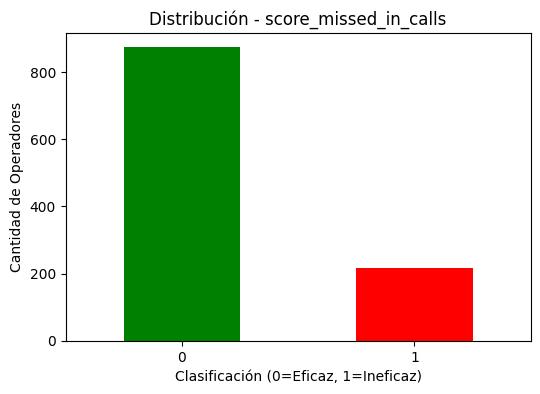

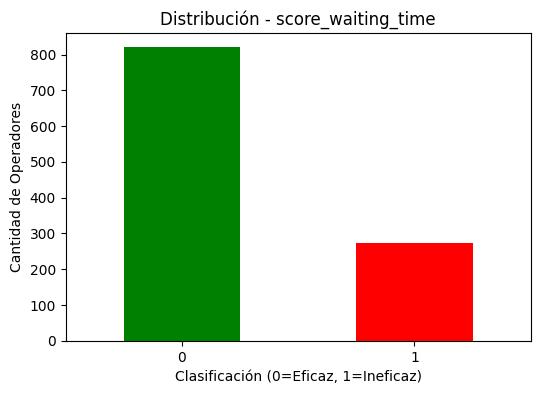

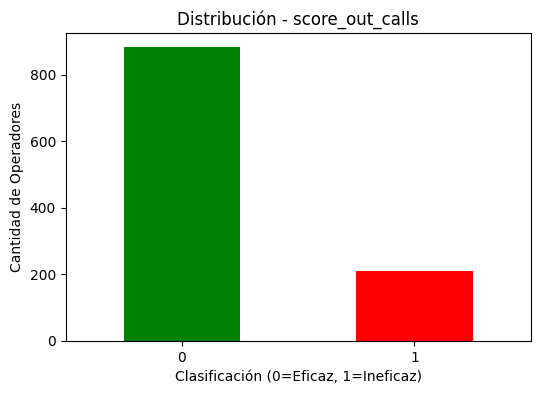

In [80]:
# Graficar las 3 métricas de ineficiencia:
# a. score_missed_in_calls: Puntuación por llamadas perdidas entrantes.
# b. score_waiting_time: Puntuación por tiempo de espera prolongado. 
# c. score_out_calls: Puntuación por baja productividad en llamadas salientes. 
metrics = ['score_missed_in_calls', 'score_waiting_time', 'score_out_calls']

# Iterar sobre cada una de las 3 métricas y crear un gráfico. 
for metric in metrics:
    plt.figure(figsize=(6, 4))
    # Contar cuántos operadores tienen valor 0 (Eficaz) y cuantos valor 1 (Ineficaz)
    df_operator_metrics[metric].value_counts().sort_index().plot(kind='bar', color=['green', 'red'])
    plt.title(f'Distribución - {metric}')
    plt.xlabel('Clasificación (0=Eficaz, 1=Ineficaz)')
    plt.ylabel('Cantidad de Operadores')
    plt.xticks(rotation=0)
    plt.show()

Observaciones: 
1. Aproximadamente 220 operadores están clasificados como ineficaces en tasa de llamadas perdidas entrantes. Esto significa que la mayoría de los operadores mantiene su tasa de perdida entrante por debajo del umbral crítico.
2. La métrica de ineficiencia que afecta la mayor número de operadores es el tiempo de espera promedio. Poco menos de 300 operadores son clasificados como ineficaces por esta métrica, es decir, aproximadamente un cuarto de los operadores está fallando en eficiencia al superar el tiempo de espera promedio de 43 segundos.
3. La distribución de la métrica de cantidad de llamadas salientes es muy similar a la de tasa de llamadas perdidas entrantes.

## 5. Prueba de hipótesis

In [47]:
# Hipótesis nula: 
# Ho: La proporción de llamadas perdidas salientes es igual o menor que la proporción de llamadas perdidas entrantes. 
# Hipótesis alternativa:
# H1: La proporción de llamadas perdidas salientes es significativamente mayor.


# Definir los parámetros de:
# Grupo de llamadas entrantes (in) - El grupo que, según H1, debería tener la mayor proporción.
total_in_calls = df_calls_control[df_calls_control["direction"] == 1].shape[0]
total_missed_in_calls = df_calls_control[(df_calls_control["direction"] == 1) & (df_calls_control["is_missed_call"] == 1)].shape[0]
# Grupo de llamadas salientes (out).
total_out_calls = df_calls_control[df_calls_control["direction"] == 0].shape[0]
total_missed_out_calls = df_calls_control[(df_calls_control["direction"] == 0) & (df_calls_control["is_missed_call"] == 1)].shape[0]


# Establecer el nivel de significancia estadística crítica.
# Si el valor-p es menor que alpha se rechaza la hipótesis nula.
alpha = 0.05


# Generar arreglos para:
# a. Llamadas perdidas.
total_missed_calls = np.array([total_missed_out_calls, total_missed_in_calls]) 
# b. Llamadas totales.
total_calls = np.array([total_out_calls, total_in_calls])   

# # Ejecución de la prueba de proporciones.
# Utilizar el parámetro alternative = "larger" para indicar que la hipótesis alternativa implica que la proporción de llamadas salientes es mayor que la de las entrantes. 
z_stat, pvalue = proportions_ztest(total_missed_calls, total_calls, alternative = "larger")
print(f'Estadístico Z: {z_stat:.4f}')
print(f'Valor p: {pvalue}')

# Probar la hipótesis:
if (pvalue < alpha):
    print("Rechazamos la hipótesis nula.")
    print("La proporción de llamadas perdidas salientes es significativamente mayor que la de llamadas entrantes.")
else:
    print("No podemos rechazar la hipótesis nula.")
    print("No hay evidencia suficiente para afirmar que la proporción de llamadas perdidas salientes sea mayor.")

Estadístico Z: 81.7793
Valor p: 0.0
Rechazamos la hipótesis nula.
La proporción de llamadas perdidas salientes es significativamente mayor que la de llamadas entrantes.


Observaciones:

El estadístico Z es extremadamente alto y positivo. La diferencia en proporción de llamadas perdidas entre llamadas salientes y entrantes es muy significativa, lo cual puede inferirse al observar el resumen de llamadas que obtuvimos previamente:

LLAMADAS ENTRANTES:
Total internas perdidas: 21,
Total externas perdidas: 663,
Total perdidas: 684

LLAMADAS SALIENTES:
Total internas perdidas: 2,391,
Total externas perdidas: 11,034,
Total perdidas: 13,425


In [46]:
# Hipótesis nula: 
# Ho: No existe correlación entre el tiempo promedio de espera de un operador y su tasa de llamadas perdidas entrantes. 
# Hipótesis alternativa:
# H1: Existe una correlación positiva entre el tiempo promedio de espera de un operador y su tasa de llamadas perdidas entrantes. 

# Establecer las métricas a comparar:
average_waiting_time = df_operator_metrics["average_waiting_time"]
in_calls_loss_rate = df_operator_metrics["in_calls_loss_rate"]

# Establecer el nivel de significancia estadística crítica.
# Si el valor-p es menor que alpha se rechaza la hipótesis nula.
alpha = 0.05

# Ejecutar el cálculo del coeficiente de correlación de Pearson.
coefficient_r, p_value = pearsonr(average_waiting_time, in_calls_loss_rate)
print(f"Coeficiente de correlación: {coefficient_r:.4f}")
print(f"Valor p: {p_value:.30f}")

if p_value < alpha:
    print("Rechazamos la hipótesis nula")
    if coefficient_r > 0:
        print("Existe una correlación positiva entre el tiempo promedio de espera y la tasa de llamadas perdidas entrantes.")
    else:
        print("Existe una correlación negativa entre el tiempo promedio de espera y la tasa de llamadas perdidas entrantes.")
else:
    print("No podemos rechazar la hipótesis nula.")
    print("No hay evidencia suficiente para afirmar que el tiempo promedio de espera tenga correlación positiva con su tasa de llamadas perdidas.")

Coeficiente de correlación: 0.3167
Valor p: 0.000000000000000000000000007338
Rechazamos la hipótesis nula
Existe una correlación positiva entre el tiempo promedio de espera y la tasa de llamadas perdidas entrantes.


Observaciones:
1. Existe una correlación positiva fuerte entre las métricas de tiempo promedio de espera y tasa de llamadas perdidas. Esto significa que los operadores con alto tiempo de espera sí tienden a tener una mayor tasa de llamadas perdidas.
2.  Los operadores más lentos generan una mayor pérdida de llamadas. 

## 6. Fuentes de documentación

1. Winsorización.
Fuente: https://medium.com/data-science-collective/winsorization-a-simple-and-effective-way-to-handle-outliers-in-your-data-e9635c3bc049. 
Información aportada: Técnica de limpieza de outliers. Aportó la metodología para ajustar valores extremos sin eliminar registros completos, preservando la mayor cantidad de datos posible.
2. Función quantile() de Pandas.
Fuente:https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html.
Información aportada: Método para calcular de forma programada cualquier percentil (P99, P80, P75, P25).
3. Función clip() de NumPy. 
Fuente: https://docs.vultr.com/python/third-party/numpy/clip.
Información aportada: Metodología de capping por percentiles para limitar valores extremos (como duraciones de llamadas de 40 horas) a un umbral razonable (P99). 
4. Prueba Z para proporciones.
Fuente:https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html.
Información aportada: La herramienta estadística para comparar la tasa de un evento binario (llamada perdida is_missed_call) entre el grupo de tráfico entrante vs el el tráfico saliente. 
5. Coeficiente de Pearson.
Fuente:https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html.
Información aportada: La herramienta estadística para determinar relación entre las métricas de tiempo promedio de espera y tasa de llamadas perdidas entrantes. 